<a target="_blank" href="https://colab.research.google.com/github/Sarthakrw/research-lab/blob/main/positional_encoding/gpt_positional_encoding.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip -qqq install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

### Load Data

In [ ]:
import requests

url = "https://raw.githubusercontent.com/karpathy/ng-video-lecture/master/input.txt"

response = requests.get(url)

if response.status_code == 200:
    dataset = response.text

In [ ]:
print(dataset[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt2")

In [ ]:
tokens = enc.encode(dataset)
tokens[:10]

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11]

In [ ]:
vocab_s = enc.n_vocab
vocab_s

50257

In [ ]:
n = int((0.9*len(tokens)))
print(n)
train_data = tokens[:n]
val_data = tokens[n:]

304222


### Data Loader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from dataclasses import dataclass

@dataclass
class GPTConfig:
    vocab_size: int = vocab_s
    n_embd: int = 128
    block_size: int = 128
    batch_size: int = 16
    n_layer: int = 8
    n_head: int = 8
    dropout: float = 0.2

config = GPTConfig()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.manual_seed(1337)

def get_batch(split):

    data = train_data if split=='train' else val_data
    idx = torch.randint(0, len(data) - config.block_size, (config.batch_size,))
    x = torch.stack([torch.tensor(data[i:i+config.block_size]) for i in idx])
    y = torch.stack([torch.tensor(data[i+1:i+config.block_size+1]) for i in idx])
    return x.to(device), y.to(device)

x_train, y_train = get_batch('train')

"""
print(x_train)
print(y_train)
print("----")

for b in range(config.batch_size):
    for t in range(config.block_size):
        context = x_train[b, :t+1]
        target = y_train[b, t]
        print("When input is: ", context, "Target is: ", target)
    print("----")
"""

'\nprint(x_train)\nprint(y_train)\nprint("----")\n\nfor b in range(config.batch_size):\n    for t in range(config.block_size):\n        context = x_train[b, :t+1]\n        target = y_train[b, t]\n        print("When input is: ", context, "Target is: ", target)\n    print("----")\n'

## Estimate Loss

In [ ]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iter)
        for k in range(eval_iter):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train()
    return out

## Baseline GPT - Absolute Positional Embeddings

In [ ]:
class Head(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.query = nn.Linear(config.n_embd, config.n_embd // config.n_head, bias=False) # (n_embd, head_size)
        self.key = nn.Linear(config.n_embd, config.n_embd // config.n_head, bias=False)   # (n_embd, head_size)
        self.value = nn.Linear(config.n_embd, config.n_embd // config.n_head, bias=False) # (n_embd, head_size)

        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))

        self.dropout = nn.Dropout(config.dropout)


    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x) # (B, T, head_size)
        k = self.key(x)   # (B, T, head_size)
        v = self.value(x)   # (B, T, head_size)

        # scaled dot product attention #

        wei = q @ k.transpose(-2, -1) / (config.n_embd // config.n_head)**0.5  # (B, T, head_size) @ (B, head_size, T) ---> (B, T, T)

        # masking future tokens due to "auto-regressive" nature
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B, T, T)

        wei = F.softmax(wei, dim=-1)                  # (B, T, T)

        wei = self.dropout(wei)

        out = wei @ v  # (B, T, T) @ (B, T, head_size) ---> (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.heads = nn.ModuleList([Head(config) for _ in range(config.n_head)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Run each head in parallel and concatenate along the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        out = self.dropout(out)

        return out


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4*config.n_embd, config.n_embd)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        x = self.dropout(x)

        return x


class Block(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.transformer.wte(idx)             # (B, T, n_embd)
        pos_emb = self.transformer.wpe(torch.arange(T, device=idx.device)) # (T, n_embd)

        x = tok_emb + pos_emb # (B, T, n_embd)

        for block in self.transformer.h:
            x = block(x) # (B, T, n_embd)

        x = self.transformer.ln_f(x) # (B, T, n_embd)

        if targets is not None:
            logits = self.lm_head(x)  # (B, T, vocab_size)
            loss = F.cross_entropy(logits.view(B*T, config.vocab_size), targets.view(B*T))
        else:
            logits = self.lm_head(x[:, [-1], :]) # (B, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, sequence, max_new_tokens):
        enc = tiktoken.encoding_for_model("gpt2")
        idx = torch.tensor(enc.encode(sequence)).unsqueeze(0).to(device) # (B, T)

        B, T = idx.shape

        out = torch.empty((B, 0), dtype=idx.dtype, device=device)

        for _ in range(max_new_tokens):
            # crop input to block_size if required
            idx = idx if idx.size(1) <= config.block_size else idx[:, -config.block_size:]
            logits, _ = self(idx) # (B, vocab_size)
            probs = F.softmax(logits.squeeze(1), dim=-1) # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

            out = torch.cat((out, idx_next), dim=1)
        return out

## NoPE

In [ ]:
class GPT_NoPE(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.transformer.wte(idx)             # (B, T, n_embd)
        #pos_emb = self.transformer.wpe(torch.arange(T, device=idx.device)) # (T, n_embd)

        x = tok_emb #+ pos_emb # (B, T, n_embd)

        for block in self.transformer.h:
            x = block(x) # (B, T, n_embd)

        x = self.transformer.ln_f(x) # (B, T, n_embd)

        if targets is not None:
            logits = self.lm_head(x)  # (B, T, vocab_size)
            loss = F.cross_entropy(logits.view(B*T, config.vocab_size), targets.view(B*T))
        else:
            logits = self.lm_head(x[:, [-1], :]) # (B, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, sequence, max_new_tokens):
        enc = tiktoken.encoding_for_model("gpt2")
        idx = torch.tensor(enc.encode(sequence)).unsqueeze(0).to(device) # (B, T)

        B, T = idx.shape

        out = torch.empty((B, 0), dtype=idx.dtype, device=device)

        for _ in range(max_new_tokens):
            # crop input to block_size if required
            idx = idx if idx.size(1) <= config.block_size else idx[:, -config.block_size:]
            logits, _ = self(idx) # (B, vocab_size)
            probs = F.softmax(logits.squeeze(1), dim=-1) # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

            out = torch.cat((out, idx_next), dim=1)
        return out

## RoPE

In [ ]:
def apply_rope(q, k):
    B, T, dim = q.shape
    device = q.device

    # Calculate rotation angles for every other dimension
    theta = 1.0 / (10000 ** (torch.arange(0, dim, 2, device=device).float() / dim))

    # Position indices
    positions = torch.arange(T, device=device).float()

    # Compute angles for each position and pair of dimensions
    idx_theta = torch.einsum('t,d->td', positions, theta)  # (T, dim//2)
    cos = torch.cos(idx_theta)  # (T, dim//2)
    sin = torch.sin(idx_theta)  # (T, dim//2)

    # Reshape for broadcasting: remove extra singleton dimension
    cos = cos.view(1, T, dim//2)  # (1, T, dim//2)
    sin = sin.view(1, T, dim//2)  # (1, T, dim//2)

    # Split last dimension into two parts
    q_rot = q.view(B, T, dim//2, 2)
    q_rot = torch.stack([
        q_rot[..., 0] * cos - q_rot[..., 1] * sin,
        q_rot[..., 1] * cos + q_rot[..., 0] * sin
    ], dim=-1).flatten(2)  # (B, T, dim)

    k_rot = k.view(B, T, dim//2, 2)
    k_rot = torch.stack([
        k_rot[..., 0] * cos - k_rot[..., 1] * sin,
        k_rot[..., 1] * cos + k_rot[..., 0] * sin
    ], dim=-1).flatten(2)  # (B, T, dim)

    return q_rot, k_rot


class Head_RoPE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.head_size = config.n_embd // config.n_head

        self.query = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.key   = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.value = nn.Linear(config.n_embd, self.head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)    # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Apply RoPE to query and key
        q_rot, k_rot = apply_rope(q, k)

        # Use rotated queries and keys to compute scaled dot-product attention
        scale = self.head_size ** 0.5
        wei = q_rot @ k_rot.transpose(-2, -1) / scale  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_size)
        return out


class MultiHeadAttention_RoPE(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.heads = nn.ModuleList([Head_RoPE(config) for _ in range(config.n_head)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Run each head in parallel and concatenate along the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(out)
        return out


class Block_RoPE(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention_RoPE(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT_RoPE(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # removed wpe
            h = nn.ModuleList([Block_RoPE(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.transformer.wte(idx)             # (B, T, n_embd)

        x = tok_emb # removed pos_emb

        for block in self.transformer.h:
            x = block(x) # (B, T, n_embd)

        x = self.transformer.ln_f(x) # (B, T, n_embd)

        if targets is not None:
            logits = self.lm_head(x)  # (B, T, vocab_size)
            loss = F.cross_entropy(logits.view(B*T, config.vocab_size), targets.view(B*T))
        else:
            logits = self.lm_head(x[:, [-1], :]) # (B, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, sequence, max_new_tokens):
        enc = tiktoken.encoding_for_model("gpt2")
        idx = torch.tensor(enc.encode(sequence)).unsqueeze(0).to(device) # (B, T)

        B, T = idx.shape

        out = torch.empty((B, 0), dtype=idx.dtype, device=device)

        for _ in range(max_new_tokens):
            # crop input to block_size if required
            idx = idx if idx.size(1) <= config.block_size else idx[:, -config.block_size:]
            logits, _ = self(idx) # (B, vocab_size)
            probs = F.softmax(logits.squeeze(1), dim=-1) # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

            out = torch.cat((out, idx_next), dim=1)
        return out

## QK Norm

In [ ]:
class Head_QK(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.head_size = config.n_embd // config.n_head

        self.query = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.key   = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.value = nn.Linear(config.n_embd, self.head_size, bias=False)

        # QK normalization layers
        self.q_norm = nn.LayerNorm(self.head_size)
        self.k_norm = nn.LayerNorm(self.head_size)

        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)    # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Apply QK normalization before RoPE
        q = self.q_norm(q)
        k = self.k_norm(k)

        # Apply RoPE to query and key
        q_rot, k_rot = apply_rope(q, k)

        # Use rotated queries and keys to compute scaled dot-product attention
        scale = self.head_size ** 0.5
        wei = q_rot @ k_rot.transpose(-2, -1) / scale  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_size)
        return out


class MultiHeadAttention_QK(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.heads = nn.ModuleList([Head_QK(config) for _ in range(config.n_head)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Run each head in parallel and concatenate along the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(out)
        return out


class Block_QK(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention_QK(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT_QK(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # removed wpe
            h = nn.ModuleList([Block_QK(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.transformer.wte(idx)             # (B, T, n_embd)

        x = tok_emb # removed pos_emb

        for block in self.transformer.h:
            x = block(x) # (B, T, n_embd)

        x = self.transformer.ln_f(x) # (B, T, n_embd)

        if targets is not None:
            logits = self.lm_head(x)  # (B, T, vocab_size)
            loss = F.cross_entropy(logits.view(B*T, config.vocab_size), targets.view(B*T))
        else:
            logits = self.lm_head(x[:, [-1], :]) # (B, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, sequence, max_new_tokens):
        enc = tiktoken.encoding_for_model("gpt2")
        idx = torch.tensor(enc.encode(sequence)).unsqueeze(0).to(device) # (B, T)

        B, T = idx.shape

        out = torch.empty((B, 0), dtype=idx.dtype, device=device)

        for _ in range(max_new_tokens):
            # crop input to block_size if required
            idx = idx if idx.size(1) <= config.block_size else idx[:, -config.block_size:]
            logits, _ = self(idx) # (B, vocab_size)
            probs = F.softmax(logits.squeeze(1), dim=-1) # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

            out = torch.cat((out, idx_next), dim=1)
        return out

## RNoPE - Hybrid Strategy

In [ ]:
class Head_RNoPE(nn.Module):
    def __init__(self, config, apply_rope=True):
        super().__init__()
        self.head_size = config.n_embd // config.n_head
        self.apply_rope = apply_rope

        self.query = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.key   = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.value = nn.Linear(config.n_embd, self.head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)    # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Conditionally apply RoPE if the flag is set.
        if self.apply_rope:
            q_rot, k_rot = apply_rope(q, k)
        else:
            q_rot, k_rot = q, k

        scale = self.head_size ** 0.5
        wei = q_rot @ k_rot.transpose(-2, -1) / scale  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_size)
        return out


class MultiHeadAttention_RNoPE(nn.Module):
    def __init__(self, config, apply_rope=True):
        super().__init__()
        # Each head is created with the same apply_rope setting.
        self.heads = nn.ModuleList([Head_RNoPE(config, apply_rope=apply_rope) for _ in range(config.n_head)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Run each head in parallel and concatenate along the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(out)
        return out


class Block_RNoPE(nn.Module):
    def __init__(self, config, apply_rope=True):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention_RNoPE(config, apply_rope=apply_rope)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT_RNoPE(nn.Module):
    def __init__(self, config, block_order=None):
        super().__init__()

        # Automatically generate an alternating pattern if block_order is not provided
        if block_order is None:
            block_order = [True if i % 2 == 0 else False for i in range(config.n_layer)]

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # No separate positional embedding
            h = nn.ModuleList([
                Block_RNoPE(config, apply_rope=block_order[i])
                for i in range(config.n_layer)
            ]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.transformer.wte(idx)  # (B, T, n_embd)
        x = tok_emb

        for block in self.transformer.h:
            x = block(x)  # (B, T, n_embd)

        x = self.transformer.ln_f(x)  # (B, T, n_embd)

        if targets is not None:
            logits = self.lm_head(x)  # (B, T, vocab_size)
            loss = F.cross_entropy(logits.view(B*T, config.vocab_size), targets.view(B*T))
        else:
            logits = self.lm_head(x[:, [-1], :])  # (B, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, sequence, max_new_tokens):
        enc = tiktoken.encoding_for_model("gpt2")
        idx = torch.tensor(enc.encode(sequence)).unsqueeze(0).to(device)  # (B, T)
        B, T = idx.shape
        out = torch.empty((B, 0), dtype=idx.dtype, device=device)
        for _ in range(max_new_tokens):
            idx = idx if idx.size(1) <= config.block_size else idx[:, -config.block_size:]
            logits, _ = self(idx)  # (B, vocab_size)
            probs = F.softmax(logits.squeeze(1), dim=-1)  # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
            out = torch.cat((out, idx_next), dim=1)
        return out

## Pre-training

In [ ]:
torch.manual_seed(1337)

model = GPT(config).to(device)
model_nope = GPT_NoPE(config).to(device)
model_rope = GPT_RoPE(config).to(device)
model_qk = GPT_QK(config).to(device)
model_rnope = GPT_QK(config).to(device)

# model = torch.compile(model)
# model_nope = torch.compile(model_nope)
# model_rope = torch.compile(model_rope)
# model_qk = torch.compile(model_qk)
# model_rnope = torch.compile(model_rnope)

In [ ]:
torch.manual_seed(1337)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
optimizer_nope = torch.optim.AdamW(model_nope.parameters(), lr=1e-4)
optimizer_rope = torch.optim.AdamW(model_rope.parameters(), lr=1e-4)
optimizer_qk = torch.optim.AdamW(model_qk.parameters(), lr=1e-4)
optimizer_rnope = torch.optim.AdamW(model_rnope.parameters(), lr=1e-4)

In [ ]:
# Lists to store loss at each iteration for plotting
train_losses_model = []
val_losses_model = []

train_losses_model_nope = []
val_losses_model_nope = []

train_losses_model_rope = []
val_losses_model_rope = []

train_losses_model_qk = []
val_losses_model_qk = []

train_losses_model_rnope = []
val_losses_model_rnope = []

In [ ]:
torch.manual_seed(1337)

max_iter = 3000
eval_iter = 200

for i in range(max_iter + 1):

    if i % eval_iter == 0:
        # Estimate losses for all five models
        losses_model      = estimate_loss(model)
        losses_model_nope = estimate_loss(model_nope)
        losses_model_rope = estimate_loss(model_rope)
        losses_model_qk   = estimate_loss(model_qk)
        losses_model_rnope = estimate_loss(model_rnope)

        # Print estimated losses
        print(f"Step {i} | GPT Train Loss: {losses_model['train']:.4f} | GPT Val Loss: {losses_model['val']:.4f}")
        print(f"       | GPT NoPE Train Loss: {losses_model_nope['train']:.4f} | GPT NoPE Val Loss: {losses_model_nope['val']:.4f}")
        print(f"       | GPT RoPE Train Loss: {losses_model_rope['train']:.4f} | GPT RoPE Val Loss: {losses_model_rope['val']:.4f}")
        print(f"       | GPT QK Train Loss: {losses_model_qk['train']:.4f} | GPT QK Val Loss: {losses_model_qk['val']:.4f}")
        print(f"       | GPT RNoPE Train Loss: {losses_model_rnope['train']:.4f} | GPT RNoPE Val Loss: {losses_model_rnope['val']:.4f}")

        # Store validation losses for plotting later
        val_losses_model.append(losses_model['val'])
        val_losses_model_nope.append(losses_model_nope['val'])
        val_losses_model_rope.append(losses_model_rope['val'])
        val_losses_model_qk.append(losses_model_qk['val'])
        val_losses_model_rnope.append(losses_model_rnope['val'])

    # Get batch
    xb, yb = get_batch('train')

    # Forward pass for all five models
    logits_1, loss_1 = model(xb, yb)
    logits_2, loss_2 = model_nope(xb, yb)
    logits_3, loss_3 = model_rope(xb, yb)
    logits_4, loss_4 = model_qk(xb, yb)
    logits_5, loss_5 = model_rnope(xb, yb)

    # Store training losses for plotting later
    train_losses_model.append(loss_1.item())
    train_losses_model_nope.append(loss_2.item())
    train_losses_model_rope.append(loss_3.item())
    train_losses_model_qk.append(loss_4.item())
    train_losses_model_rnope.append(loss_5.item())

    # Backward pass and optimization for each model
    optimizer.zero_grad(set_to_none=True)
    loss_1.backward()
    optimizer.step()

    optimizer_nope.zero_grad(set_to_none=True)
    loss_2.backward()
    optimizer_nope.step()

    optimizer_rope.zero_grad(set_to_none=True)
    loss_3.backward()
    optimizer_rope.step()

    optimizer_qk.zero_grad(set_to_none=True)
    loss_4.backward()
    optimizer_qk.step()

    optimizer_rnope.zero_grad(set_to_none=True)
    loss_5.backward()
    optimizer_rnope.step()

Step 0 | GPT Train Loss: 11.0131 | GPT Val Loss: 11.0116
       | GPT NoPE Train Loss: 10.9779 | GPT NoPE Val Loss: 10.9923
       | GPT RoPE Train Loss: 10.9468 | GPT RoPE Val Loss: 10.9326
       | GPT QK Train Loss: 10.9663 | GPT QK Val Loss: 10.9544
       | GPT RNoPE Train Loss: 10.9918 | GPT RNoPE Val Loss: 11.0022
Step 200 | GPT Train Loss: 6.9897 | GPT Val Loss: 7.0068
       | GPT NoPE Train Loss: 6.9289 | GPT NoPE Val Loss: 6.9729
       | GPT RoPE Train Loss: 6.9216 | GPT RoPE Val Loss: 6.9349
       | GPT QK Train Loss: 6.9685 | GPT QK Val Loss: 6.9985
       | GPT RNoPE Train Loss: 6.9125 | GPT RNoPE Val Loss: 6.9656
Step 400 | GPT Train Loss: 6.1910 | GPT Val Loss: 6.2738
       | GPT NoPE Train Loss: 6.1013 | GPT NoPE Val Loss: 6.2025
       | GPT RoPE Train Loss: 6.0922 | GPT RoPE Val Loss: 6.1570
       | GPT QK Train Loss: 6.0730 | GPT QK Val Loss: 6.1561
       | GPT RNoPE Train Loss: 6.0894 | GPT RNoPE Val Loss: 6.1675
Step 600 | GPT Train Loss: 5.9928 | GPT Val Los

## Save Losses

In [ ]:
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/My Drive/projects/gpt/losses_dict.pkl'

# Create a dictionary with all your loss lists
losses_dict = {
    'train_losses_model': train_losses_model,
    'train_losses_model_nope': train_losses_model_nope,
    'train_losses_model_rope': train_losses_model_rope,
    'train_losses_model_qk': train_losses_model_qk,
    'train_losses_model_rnope': train_losses_model_rnope,
    'val_losses_model': val_losses_model,
    'val_losses_model_nope': val_losses_model_nope,
    'val_losses_model_rope': val_losses_model_rope,
    'val_losses_model_qk': val_losses_model_qk,
    'val_losses_model_rnope': val_losses_model_rnope
}

# Save the dictionary to a file
with open(save_path, 'wb') as f:
    pickle.dump(losses_dict, f)

# Confirm the file is saved
print("Saved losses to:", save_path)
print("Files in target folder:", os.listdir('/content/drive/My Drive/projects/gpt/'))

Saved losses to: /content/drive/My Drive/projects/gpt/losses_dict.pkl
Files in target folder: ['losses_dict.pkl']


In [ ]:
from tabulate import tabulate

final_losses = [
    ["Model", "Train Loss", "Validation Loss"],
    ["GPT", f"{train_losses_model[-1]:.4f}", f"{val_losses_model[-1]:.4f}"],
    ["GPT NoPE", f"{train_losses_model_nope[-1]:.4f}", f"{val_losses_model_nope[-1]:.4f}"],
    ["GPT RoPE", f"{train_losses_model_rope[-1]:.4f}", f"{val_losses_model_rope[-1]:.4f}"],
    ["GPT QK Norm", f"{train_losses_model_qk[-1]:.4f}", f"{val_losses_model_qk[-1]:.4f}"],
    ["GPT RNoPE", f"{train_losses_model_rnope[-1]:.4f}", f"{val_losses_model_rnope[-1]:.4f}"]
]

print(tabulate(final_losses, headers="firstrow", tablefmt="fancy_grid"))

╒═════════════╤══════════════╤═══════════════════╕
│ Model       │   Train Loss │   Validation Loss │
╞═════════════╪══════════════╪═══════════════════╡
│ GPT         │       4.5634 │            5.1413 │
├─────────────┼──────────────┼───────────────────┤
│ GPT NoPE    │       4.364  │            4.9978 │
├─────────────┼──────────────┼───────────────────┤
│ GPT RoPE    │       4.1833 │            4.7863 │
├─────────────┼──────────────┼───────────────────┤
│ GPT QK Norm │       4.1835 │            4.831  │
├─────────────┼──────────────┼───────────────────┤
│ GPT RNoPE   │       4.1811 │            4.8308 │
╘═════════════╧══════════════╧═══════════════════╛


## Plot Training

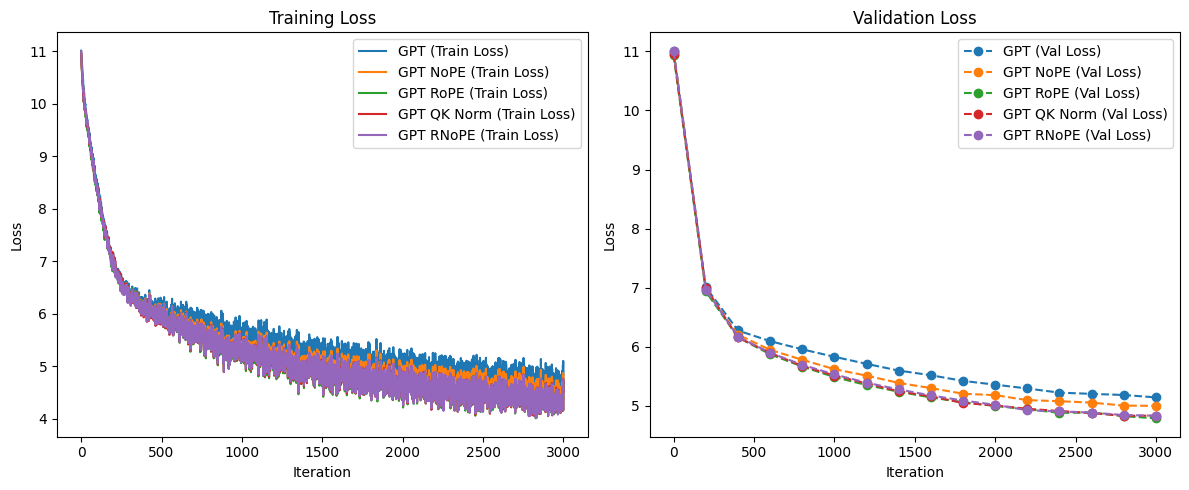

In [ ]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(12, 5))

# --- Training Loss Subplot ---
ax_train.plot(train_losses_model,      label="GPT (Train Loss)")
ax_train.plot(train_losses_model_nope, label="GPT NoPE (Train Loss)")
ax_train.plot(train_losses_model_rope, label="GPT RoPE (Train Loss)")
ax_train.plot(train_losses_model_qk,   label="GPT QK Norm (Train Loss)")
ax_train.plot(train_losses_model_rnope, label="GPT RNoPE (Train Loss)")

ax_train.set_xlabel("Iteration")
ax_train.set_ylabel("Loss")
ax_train.set_title("Training Loss")
ax_train.legend()

# --- Validation Loss Subplot ---
eval_steps = list(range(0, max_iter + 1, eval_iter))
ax_val.plot(eval_steps, val_losses_model,       marker='o', linestyle='dashed', label="GPT (Val Loss)")
ax_val.plot(eval_steps, val_losses_model_nope,  marker='o', linestyle='dashed', label="GPT NoPE (Val Loss)")
ax_val.plot(eval_steps, val_losses_model_rope,  marker='o', linestyle='dashed', label="GPT RoPE (Val Loss)")
ax_val.plot(eval_steps, val_losses_model_qk,    marker='o', linestyle='dashed', label="GPT QK Norm (Val Loss)")
ax_val.plot(eval_steps, val_losses_model_rnope, marker='o', linestyle='dashed', label="GPT RNoPE (Val Loss)")

ax_val.set_xlabel("Iteration")
ax_val.set_ylabel("Loss")
ax_val.set_title("Validation Loss")
ax_val.legend()

plt.tight_layout()
plt.show()

## Inference

In [ ]:
torch.manual_seed(1337)

ans = model_rnope.generate("First Citizen:", max_new_tokens=200)
ans = enc.decode(ans.squeeze().tolist())

print(ans)


for lay any speechain? one that same wcor TJ executed be laughter
HisSymmen's hated trades,
Within not det half of herorvious y own men
Or preserveing being poor kindness in You, and in these he,
Edward tou perceiveack more widow of os
Having refer every harm widow shows day and oManager,
My voice is pale one word are too,
Unless ourpirkeeping torment act.
Wra restraint he is thine breast orear
Y AN living my unSo with hence:
And bear this a loose raven of Herepapers;
But me callost thou come that More and lords,
And trouble ever rash a leave in bread.

 night growULIUS:
And when I intend.
Ay, currentter I murder less.

ROMEO:
A C faire wall, keeps it-- borough. Look the Vols!

KING HENRY BOLINGHAM:
Right


# Rough work:

In [ ]:
torch.manual_seed(1337)

B, T, C = 4, 8, 2
x = torch.randn(B,T,C)

wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

xbow2 = wei @ x

In [ ]:
xbow = torch.full((B, T, C), torch.nan)

for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t,c)
        xbow[b, t] = torch.mean(xprev, 0)

xbow.shape

torch.Size([4, 8, 2])

In [ ]:
# 3rd version
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T,T)
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
head_size=16

query = nn.Linear(C, head_size, bias=False)
key = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

q = query(x) # (B, T, head_size)
k = key(x)   # (B, T, head_size)
v = value(x)   # (B, T, head_size)

wei = q @ k.transpose(-2, -1)

tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)

out = wei @ v

out[0]

tensor([[ 0.0492,  0.0428, -0.0476,  0.0550, -0.1262, -0.0838, -0.1170,  0.0392,
          0.0727,  0.0870, -0.0828, -0.0079, -0.0775,  0.0866, -0.0804, -0.0779],
        [-0.2421,  0.0915,  0.3643, -0.3591, -0.2111,  0.0130, -0.1135, -0.3222,
         -0.3305, -0.1326,  0.2511,  0.1714, -0.0643,  0.2988,  0.3309,  0.4067],
        [ 0.0251,  0.0822,  0.0017,  0.0104, -0.2306, -0.1225, -0.1974, -0.0058,
          0.0425,  0.1033, -0.0734,  0.0224, -0.1285,  0.1890, -0.0539, -0.0351],
        [ 0.1752,  0.0959, -0.1939,  0.2123, -0.2938, -0.2236, -0.2878,  0.1637,
          0.2537,  0.2544, -0.2655, -0.0529, -0.1925,  0.1728, -0.2742, -0.2818],
        [ 0.1606,  0.0437, -0.1968,  0.2077, -0.1476, -0.1466, -0.1630,  0.1691,
          0.2287,  0.1900, -0.2206, -0.0679, -0.1113,  0.0523, -0.2419, -0.2618],
        [-0.2742,  0.0664,  0.3966, -0.3959, -0.1365,  0.0640, -0.0435, -0.3490,
         -0.3777, -0.1866,  0.3036,  0.1778, -0.0179,  0.2490,  0.3828,  0.4577],
        [ 0.1056,  0.0